<a href="https://colab.research.google.com/github/ep1lept1c/MSU_DL/blob/main/MSU_DL_11_Captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Введение в глубокое обучение

## Занятие 11. Contrastive Learning, Face Recognition, Image Captioning

##### Автор: [Татьяна Гайнцева](https://www.linkedin.com/in/tgaintseva/), @atmyre

## Contrastive Learning и распознавание лиц

Сейчас мы познакомимся с тем, как обычно устроен пайплайн распознавания лиц.

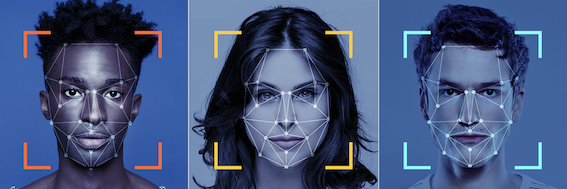

В распознавании лиц есть три этапа:
- детекция лица;
- face align (выравнивание лица);
- распознавание лица.

### 1. Детекция лица

Подразумевается, что пайплайн распознавания лиц должен работать в "полевых" условиях. То есть, распознавать лица с камер наблюдения в условиях города/здания и т.п.

На подобные камеры наблюдения обычно поступает картинка, где находятся сразу много лиц разных размеров, с разными углами поворота. И первая задача пайплайна распознавания лиц — выделить из такой картинки места, где находятся лица.

Для этого используются модели, обученные на задачу детекции человеческих лиц. Такие, которые мы упоминали на занятии по детекции и сегментации.

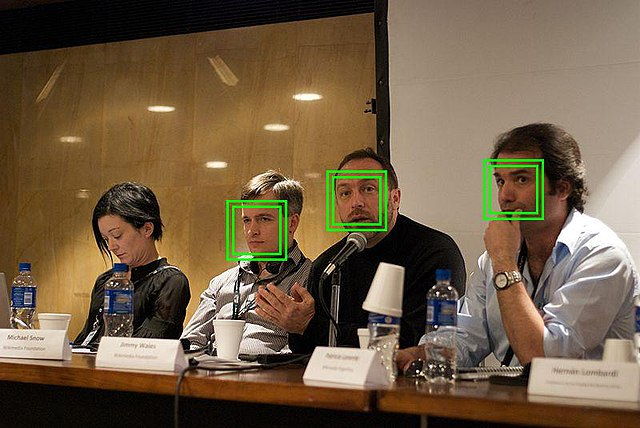

### 2. Выравнивание лица

После этапа детекции работа с каждым детектированным лицом идет по отдельности
(точнее, с bounding box'ами каждого детектированного лица).

Второй этап — выравнивание лица. Он состоит из двух этапов:
1. На картинке ищутся ключевые точки лица (обычно это координаты зрачков глаз, кончик носа и точки вокруг рта). Для этой задачи используется отдельная модель (возможно, тоже нейросеть). У PyTorch есть [туториал](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html) с кодом и описанием того, как подобная модель работает;
2. Повернуть и растянуть изображение так, чтобы точки глаз лица лежали на заданной горизонтальной линии, и чтобы между зрачками глаз было определенное расстояние.

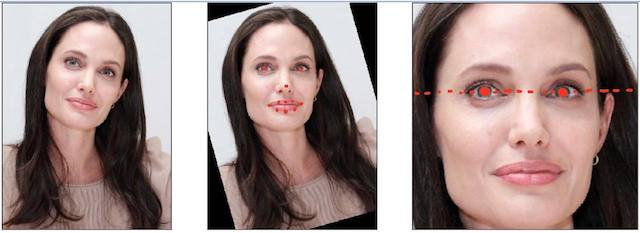

После этого все лица будут выглядеть как-то так:

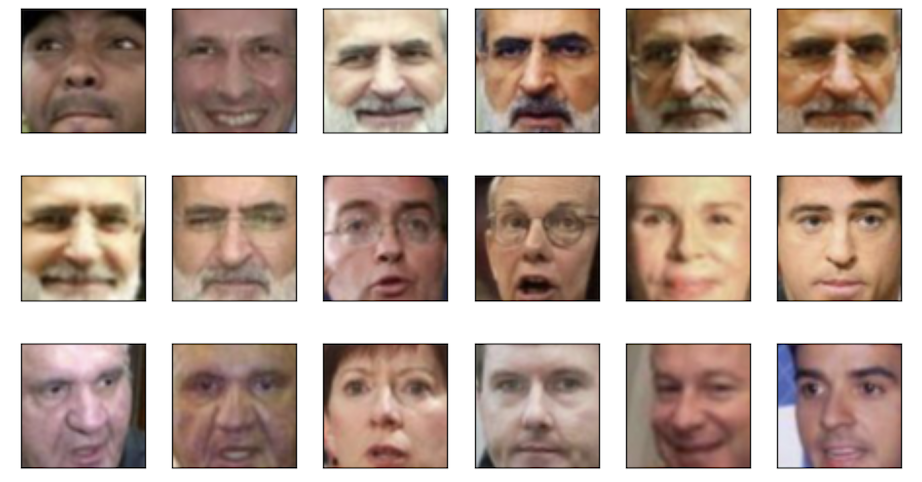

На таких картинках лиц и будет работать третья часть пайплайна — нейросеть, которая распознает лица.

**Зачем нужна стадия выравнивания**: выравнивание лиц датасета делает задачу распознавания лиц проще для модели на третьей стадии пайплайна. Если у всех лиц, которые принимает на вход модель, примерно одинаковый размер и все ключевые части (глаза, нос, рот) находятся в примерно одинаковых местах, это упрощает модели задачу понимания того, что за человек изображен на картинке. Модели не нужно "искать" глаза, рот и т.п. на картинке.

### 3. Распознавание лиц

Третья часть пайплайна — это, собственно, распознавание лиц. Что такое "распознавание": мы хотим построить такую нейросеть, которая принимает на вход картинку лица, а выдает вектор определенного размера. И мы хотим, чтобы векторы лиц одного и того же человека были близки по некоторому расстоянию (например, косинусному), а векторы лиц разных людей были далеки по этому же расстоянию.



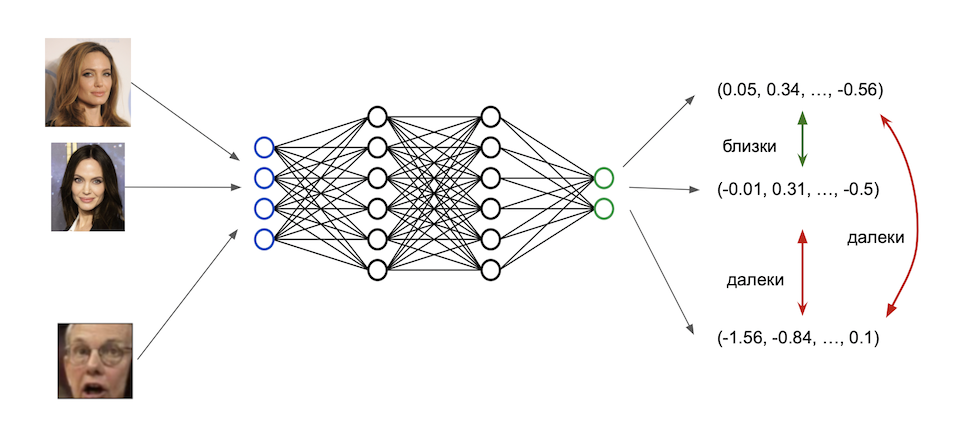

Как это можно сделать:
1. Можно обучить нейросеть на обучающей выборке лиц на задачу классификации. Каждый отдельный человек — это один класс. Затем, после обучения сети, выкинуть последний слой и считать вектором лица выход предпоследнего слоя сети. Это будет работать: полученные таким образом векторы лиц действительно будут близки для лиц одного и того же человека, и далеки для лиц разных людей. Причем это будет работать даже на тех лицах, которые не было в обучающей выборке (при условии, что обучающая выборка достаточно велика).

    У этого подхода есть недостаток: классов в обучающем датасете может быть очень много. Из-за этого последний слой сети станет очень широким. Это сделает обучение сети вычислительно затратным и сложным по памяти.
2.  Можно пойти другим путем: обучать сеть напрямую на задачу "выдавать похожие эмбеддинги для лиц одного и того же человека, и далекие эмбеддинги для лиц разных людей". Это называется **contrastive training**.
    
    На каждой итерации обучения тогда происходит следующее:
    - берется картинка лица, к ней выбирается позитивная пара (еще одна картинка лица того же человека) и негативная (картинка лица другого человека). Все три картинки подаются на вход сети, на выходе получаются три вектора. Далее считается расстояние между векторами 1 и 2 и расстояние между векторами 1 и 3. Нейросеть обучается так, чтобы расстояние между векторами 1 и 2 было как можно меньше, а расстояние между векторами 1 и 3 — как можно больше.


Лосс-функция выглядит так:

 $$L = D(anchor, positive) - D(anchor, negative)$$

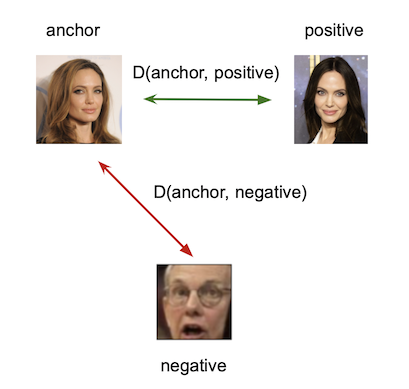

Есть еще много разных идей обучения сетей и разных лосс-функций. Contrastive learning применяется также для обучения нейросетей на изображениях в self-supervised режиме. Подробнее про это [можно почитать тут](https://www.v7labs.com/blog/contrastive-learning-guide#:~:text=Contrastive%20Learning%20is%20a%20technique,a%20data%20class%20from%20another.).

## Image Captioning

Image captioning — это когда мы подаем модели картинку, а она возвращает нам текст с описанием того, что на ней изображено.

Как мы узнали из курса, для обработки изображений и текста используются разные архитектуры нейросетей (CNN/RNN). Поэтому архитектура для задачи image captioning будет содержать и CNN-часть, и RNN-часть.




![img](https://i.imgur.com/obITaMl.png)

Устройство модели показано на картинке выше. Вот как она будет работать:
- Картинка подается на вход сверточной части сети. Это может быть, например, предобученная ResNet/VGG/... Мы возьмем предобученную Inception-v3. На выходе получаем вектор предпоследнего слоя этой сети. Этот вектор как бы содержит информацию о том, что изображено на входящей картинке.
- Выход предпоследнего слоя предобученной Inception-v3 подается на вход RNN-части сети. Эта часть учится на основе полученного на вход вектора картинки шаг за шагом генерировать описание этой картинки. Эту часть мы будем обучать с нуля.

Мы будем использовать датасет: MSCOCO: [описание](http://cocodataset.org/#download), [ссылка для скачивания](https://yadi.sk/d/HR_cHsJcbMpL-g). В этом датасете лежат пары (картинка, текст-описание).

План работы:
1. Скачаем датасет (векторы картинок и соответствующие описания) и предобработаем текстовые описания;
2. В качестве первой сети возьмем Inception-v3 и скачаем к ней предобученные веса;
3. Напишем RNN-сеть, которая будет брать векторы из Inception-v3 и генерировать описания;
4. Обучим вторую сеть на датасете MSCOCO.

## Image Captioning: Практика

Ячейка ниже скачивает вспомогательные файлы, которые нам понадобятся:

In [ ]:
! pip install wldhx.yadisk-direct

!curl -L $(yadisk-direct https://disk.yandex.com.tr/d/FVQ6Hk2TN2jQrw) -o handout.tar
! tar -xvf handout.tar

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  956M  100  956M    0     0  83.2M      0  0:00:11  0:00:11 --:--:-- 85.5M
data/
data/captions_tokenized.json
data/image_codes.npy


Мы получили три файла:
- data/images_codes.npy — выходы предпоследнего слоя сети Inception-v3 для картинок из датасета COCO;
- data/captions_tokenized.json — токенизированные описания к картинкам из датасета COCO;
- beheaded_inception3.py — код с архитектурой сети Inception-v3. Он понадобится нам, когда мы будем тестировать обученную нейросеть на новых картинках.

Загрузим данные:

In [ ]:
import numpy as np
import json

# загружаем датасет
img_codes = np.load("data/image_codes.npy")
captions = json.load(open('data/captions_tokenized.json'))

Посмотрим, как выглядят данные:

In [ ]:
# посмотрим на датасет
print("Выход предпоследнего слоя Inception-v3 для каждой картинки — это вектор длины 2048")
print("Вектор для первой картинки в датасете:")
print(img_codes[0], end='\n\n')
print("Для каждой картинки есть 5 вариантов текстовых описаний:\n")
print('\n'.join(captions[0]))

Выход предпоследнего слоя Inception-v3 для каждой картинки — это вектор длины 2048
Вектор для первой картинки в датасете:
[0.3659946  0.2016555  0.9245725  ... 0.00344942 0.99817497 1.1091837 ]

Для каждой картинки есть 5 вариантов текстовых описаний:

people shopping in an open market for vegetables .
an open market full of people and piles of vegetables .
people are shopping at an open air produce market .
large piles of carrots and potatoes at a crowded outdoor market .
people shop for vegetables like carrots and potatoes at an open air market .


### 1. Обработка текстовых описаний

Как можно видеть, в датасете все captions (тексты-описания) уже токенизированы и приведены в нижний регистр. Нам осталось сделать следующее:

1. Добавить ко всем описаниям символы начала и конца предложения;
2. Посчитать частоту встречаемости каждого слова из словаря и оставить только те, которые встречаются больше Х раз (например, Х=5);
3. Создать словарь из оставшихся слов + символов начала, конца предложения и PAD символа;
4. Написать функцию, которая будет возвращать батч из описаний. Батч должен выглядеть примерно так:

    [

    [   1,  525, 8955, 5392, 9640, 4713, 7470,  525, 7341, 2296, 7696,2,    3,    3,    3,    3,    3,    3,    3],
   
    [   1,  525, 8955, 6784, 3557,  525, 7341, 2296,    2,    3,    3,3,    3,    3,    3,    3,    3,    3,    3],

    [   1,  525, 8955, 9209, 3557, 5486, 8335, 3071, 2296,    2,    3,3,    3,    3,    3,    3,    3,    3,    3],

    [   1, 6292, 1508, 8955, 9209, 6784, 3557, 3071, 6971, 5520, 7696,2,    3,    3,    3,    3,    3,    3,    3],

    [   1,  525, 8955, 6784, 3557,  525, 7341, 6919, 2919, 6292,  250,393,  525, 4618, 8335, 6292, 7882, 7696,    2]

    ]
         
То есть:
- Короткие предложения дополняются PAD символами (индекс 3);
- Слишком длинные предложения обрезаются;
- В начале и конце предложения добавляются коды символа начала и конца предложения (индексы 1 и 2)

In [ ]:
from torch.utils.data import random_split, DataLoader
from collections import Counter
import string

In [ ]:
# заводим счетчик: сколько раз каждый токен встречается в нашем наборе описаний
token_counter = Counter()

# проходимся по пятеркам описаний для каждой картинки, и из каждого
# описания из пятерки выделяем токены. Для каждого токена увеличиваем
# счетчик token_counter[токен]
for caption_set in captions:
  for caption in caption_set:
    tokens = caption.split()
    for token in tokens:
      if token not in string.punctuation:
        token_counter[token] += 1

# заводим массив токенов. Сразу добавляем туда три вспомогательных токена.
tokens = ['<PAD>', '<BOS>', '<EOS>']
# минимальное кол-во раз, которое токен должен встречаться в датасете, чтобы мы
# его добавили в наш массив токенов
min_token_count = 5
# проходимся по нашему счетчику токенов. Добавляем в массив tokens те токены,
# счетчик которых больше чем min_token_count
for token, count in token_counter.items():
  if count > min_token_count:
    tokens.append(token)

# заводим словарь, где каждому токену ставим в соответствие уникальный индекст
token_to_idx = {x: i for i, x in enumerate(tokens)}

# длина массива токенов — это размер нашего итогового словаря
vocab_size = len(tokens)
print(f'Vocab size is {vocab_size}')

Vocab size is 9490


Напишем функцию, которая будет принимать на вход текст-описание и переводить его в вектор чисел:

In [ ]:
def tokenize_caption(caption, max_caption_length=15):
    # "people shopping in an open market for vegetables ."
    tokens = caption.split()
    tokens = tokens[:max_caption_length-2]
    tokens = ['<BOS>'] + tokens + ['<EOS>']

    return [token_to_idx[x] for x in tokens if x in token_to_idx]

In [ ]:
tokenize_caption('dog chases cat')

[1, 46, 7462, 393, 2]

Переведем в векторы чисел все описания из датасета:

In [ ]:
encoded_captions = [
  [
    tokenize_caption(caption)
    for caption in caption_set
  ]
  for caption_set in captions
]

encoded_captions[:2]

[[[1, 3, 4, 5, 6, 7, 8, 9, 10, 2],
  [1, 6, 7, 8, 11, 12, 3, 13, 14, 12, 10, 2],
  [1, 3, 15, 4, 16, 6, 7, 17, 18, 8, 2],
  [1, 19, 14, 12, 20, 13, 21, 16, 22, 23, 24, 8, 2],
  [1, 3, 25, 9, 10, 26, 20, 13, 21, 16, 6, 7, 17, 8, 2]],
 [[1, 22, 27, 28, 29, 22, 30, 31, 2],
  [1, 22, 27, 28, 29, 22, 30, 32, 31, 2],
  [1, 22, 27, 33, 34, 35, 36, 29, 22, 30, 37, 2],
  [1, 22, 38, 39, 28, 29, 22, 29, 31, 37, 2],
  [1, 22, 38, 39, 40, 41, 33, 22, 42, 30, 37, 2]]]

### 2. Создание датасета

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import random

class CaptioningDataset(Dataset):
    def __init__(self, encoded_captions, img_codes, max_caption_length=15):
        self.encoded_captions = encoded_captions
        self.img_codes = img_codes

        # зададим максимальную длину кэпшена
        self.max_caption_length = max_caption_length

    def __getitem__(self, index):
        '''
        этот метод должен по заданному номеру пары картинка-описание (index)
        возвращать эту пару.
        '''
        # берем вектор картинки по индексу
        image_code = self.img_codes[index]

        # берем векторы кэпшенов по индексу
        caption_set = self.encoded_captions[index]
        # выбираем случайный вектор кэпшена
        caption = random.choice(caption_set)

        # создаем вектор длины max_caption_length из нулей
        caption_tensor = torch.zeros(self.max_caption_length, dtype=torch.long)
        # заполняем начало вектора значениями из caption
        caption_tensor[:len(caption)] = torch.LongTensor(caption)

        return {'caption': caption_tensor, 'code': torch.FloatTensor(image_code)}

    def __len__(self):
        '''
        этот метод должен возвращать количество пар картинка-описание в датасете
        '''
        return len(self.img_codes)

In [ ]:
dataset = CaptioningDataset(encoded_captions, img_codes)
dataset[0]

{'caption': tensor([ 1,  3, 25,  9, 10, 26, 20, 13, 21, 16,  6,  7, 17,  8,  2]),
 'code': tensor([0.3660, 0.2017, 0.9246,  ..., 0.0034, 0.9982, 1.1092])}

Делим датасет на train и test:

In [ ]:
train_size = int(len(dataset)*0.9)
val_size = len(dataset) - train_size
print('Train size:', train_size, 'val size:', val_size)

train_data, val_data = random_split(dataset, [train_size, val_size])

Train size: 106458 val size: 11829


Заводим даталоадеры:

In [ ]:
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)

Посмотрим на батч описаний:

In [ ]:
(next(iter(train_loader)))['caption']

tensor([[   1,   22,   55,  230,   22, 1732,  838,  407,   33,   43,  303,   49,
           22,  730,    2],
        [   1,   22,  258,   49,  614,  175,  114,  614,  471,  189,  114,   22,
           55,    2,    0],
        [   1,   22,   59,   12,  187,   15,   91,    5,   22,  268,   63,    2,
            0,    0,    0],
        [   1,   22,  522, 3435,  490,  655,   39,  919,   56,   10,   33,   75,
            2,    0,    0],
        [   1,  315,  156, 2127,   13,  315,   44, 2127,   91,    5, 2446,    2,
            0,    0,    0],
        [   1,   22,  274,  686,   39,   49,   33,  114,   22,  786,    2,    0,
            0,    0,    0],
        [   1,   43,   55,   39,  727,  114,  511, 2689,   43,  495,    2,    0,
            0,    0,    0],
        [   1,    6, 1153,   39, 6303,  184, 1307,  110,   13,   39,  207,  618,
          114, 2010,    2],
        [   1,   22,   55,   56,   22,  171,  469,  173,    5,   71, 1134,    2,
            0,    0,    0],
        [   1,   45

### 3. Архитектура RNN для генерации описаний


In [ ]:
import torch, torch.nn as nn
import torch.nn.functional as F

In [ ]:
class CaptionNet(nn.Module):
    def __init__(self, vocab_size, cnn_feature_size=2048, hidden_dim=512, emb_dim=256, n_layers=2, dropout=0.25):
        super(self.__class__, self).__init__()

        # слой для перевода вектора картинки в начальные значения для скрытых состояний lstm
        self.feature_fc = nn.Linear(cnn_feature_size, hidden_dim)
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.rnn = nn.LSTM(emb_dim, hidden_dim, num_layers=n_layers, dropout=dropout, batch_first=True)
        self.out = nn.Linear(hidden_dim, vocab_size)

    def forward(self, image_vectors, captions_ix):
        image_emb = self.feature_fc(image_vectors).unsqueeze(0).repeat_interleave(self.rnn.num_layers, dim=0)

        captions_emb = self.embedding(captions_ix)
        output, (h_n, c_n) = self.rnn(captions_emb, (image_emb, image_emb))

        # [batch_size, vocab_size, seq_length]
        logits = self.out(output).transpose(1, 2)

        return logits

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
model = CaptionNet(vocab_size).to(device)

### 4. Обучение сети

In [ ]:
from IPython.display import clear_output
import matplotlib.pyplot as plt

def evaluate(model, dataloader, loss_fn):
    losses = []

    for i, batch in enumerate(dataloader):

        # так получаем текущий батч
        images_batch, captions_batch = batch['code'].to(device), batch['caption'].to(device)

        with torch.no_grad():
            logits = model(images_batch, captions_batch)
            if i == 0:
                print("Real:", [tokens[x] for x in captions_batch[0]])
                last_softmax = F.softmax(logits, dim=1)
                gen_idx = torch.argmax(last_softmax, dim=1)
                print("Generated:", [tokens[x] for x in gen_idx[0]])

            target = captions_batch.new_zeros(captions_batch.shape)
            target[:, :-1] = captions_batch[:, 1:]

            loss = loss_fn(logits, target)
            losses.append(loss.item())

    return np.mean(losses)

def train(model, loss_fn, optimizer, n_epoch=3):

    train_history = []
    val_history = []

    # цикл обучения сети
    for epoch in range(n_epoch):

        print("Epoch:", epoch)

        model.train(True)
        local_train_history = []

        for i, batch in enumerate(train_loader):
            # так получаем текущий батч
            images_batch, captions_batch = batch['code'].to(device), batch['caption'].to(device)

            # forward pass (получение ответов на батч картинок)
            logits = model(images_batch, captions_batch)

            target = captions_batch.new_zeros(captions_batch.shape)
            target[:, :-1] = captions_batch[:, 1:]
            # '<BOS> a group of ...'
            # 'a group of ...'

            loss = loss_fn(logits, target)
            local_train_history.append(loss.item())
            loss.backward() # backpropagation (вычисление градиентов)
            optimizer.step() # обновление весов сети
            optimizer.zero_grad() # обнуляем веса

            #########################
            # Логирование результатов
            if i % 100 == 0:
                clear_output(True)
                train_history.append(np.mean(local_train_history))
                local_train_history = []

                model.train(False)
                val_loss = evaluate(model, val_loader, loss_fn=loss_fn)
                val_history.append(val_loss)
                model.train(True)

                fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
                ax[0].plot(list(range(len(train_history))), train_history, label='train loss')
                ax[0].set_xlabel('Batch')
                ax[0].set_title('Train loss')
                if val_history is not None:
                    ax[1].plot(list(range(len(val_history))), val_history, label='val history')
                    ax[1].set_xlabel('Batch')
                    ax[1].set_title('Val loss')
                plt.legend()
                plt.show()
            #########################

    return model

Real: ['<BOS>', 'a', 'man', 'with', 'a', 'helmet', 'stands', 'next', 'to', 'a', 'van', '<EOS>', '<PAD>', '<PAD>', '<PAD>']
Generated: ['a', 'man', 'is', 'a', 'red', 'on', 'next', 'to', 'a', 'truck', '<EOS>', '<EOS>', '<EOS>', '<EOS>', '<EOS>']


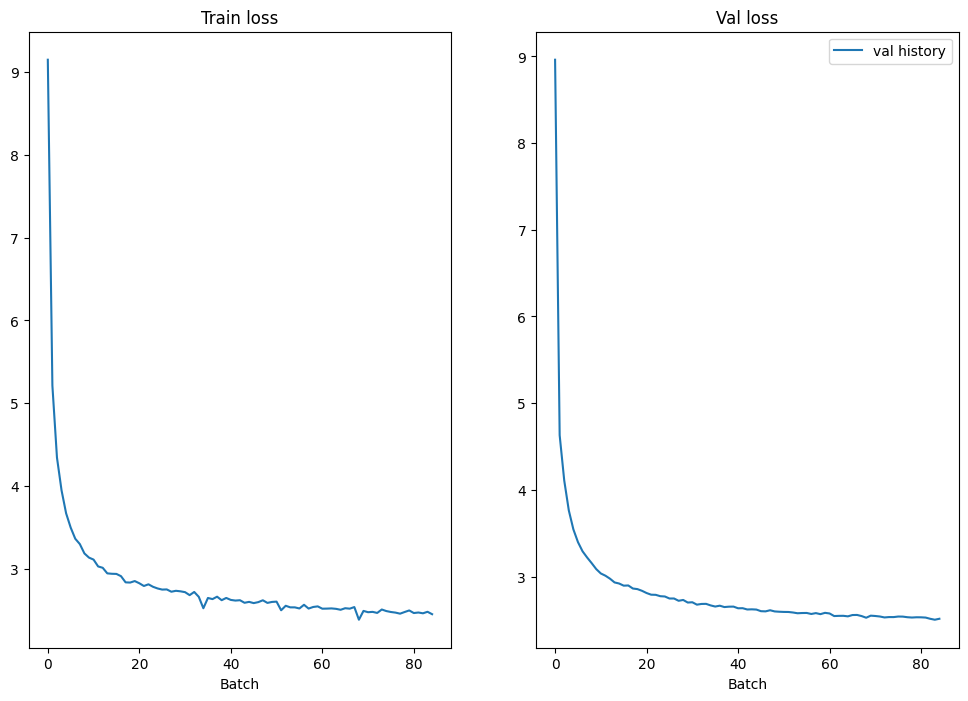

In [ ]:
model = CaptionNet(vocab_size).to(device)

# выбираем функцию потерь
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=0)

# выбираем алгоритм оптимизации и learning_rate
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

model = train(model, loss_fn, optimizer, n_epoch=5)

In [ ]:
torch.save(model.state_dict(), "model.pt")

### 5. Загрузка Inseption и получение результатов


Ячейка ниже загружает предобученные веса для Inception-v3:

In [ ]:
!curl -L $(yadisk-direct https://disk.yandex.com.tr/d/XDKIRBf3H0qkgg) -o inception_weights.pth

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  103M  100  103M    0     0  44.9M      0  0:00:02  0:00:02 --:--:-- 96.5M


Код самой сети Inception-v3:

In [ ]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.models.inception import Inception3
from warnings import warn

class BeheadedInception3(Inception3):
    """ Like torchvision.models.inception.Inception3 but the head goes separately """

    def forward(self, x):
        if self.transform_input:
            x = x.clone()
            x[:, 0] = x[:, 0] * (0.229 / 0.5) + (0.485 - 0.5) / 0.5
            x[:, 1] = x[:, 1] * (0.224 / 0.5) + (0.456 - 0.5) / 0.5
            x[:, 2] = x[:, 2] * (0.225 / 0.5) + (0.406 - 0.5) / 0.5
        else: warn("Input isn't transformed")
        x = self.Conv2d_1a_3x3(x)
        x = self.Conv2d_2a_3x3(x)
        x = self.Conv2d_2b_3x3(x)
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        x = self.Conv2d_3b_1x1(x)
        x = self.Conv2d_4a_3x3(x)
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        x = self.Mixed_5b(x)
        x = self.Mixed_5c(x)
        x = self.Mixed_5d(x)
        x = self.Mixed_6a(x)
        x = self.Mixed_6b(x)
        x = self.Mixed_6c(x)
        x = self.Mixed_6d(x)
        x = self.Mixed_6e(x)
        x = self.Mixed_7a(x)
        x = self.Mixed_7b(x)
        x_for_attn = x = self.Mixed_7c(x)
        # 8 x 8 x 2048
        x = F.avg_pool2d(x, kernel_size=8)
        # 1 x 1 x 2048
        x_for_capt = x = x.view(x.size(0), -1)
        # 2048
        x = self.fc(x)
        # 1000 (num_classes)
        return x_for_attn, x_for_capt, x

def beheaded_inception_v3(transform_input=True):
    inception = BeheadedInception3(transform_input=transform_input)
    inception.load_state_dict(torch.load('inception_weights.pth'))
    return inception

inception = beheaded_inception_v3()

/usr/local/lib/python3.10/dist-packages/torchvision/models/inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


Генерируем описание:

In [ ]:
def generate_caption(model, image, caption_prefix=1,
                     t=1, sample=True, max_len=15, code=None):

    model.eval()
    with torch.no_grad():
        image = torch.tensor(image.transpose([2, 0, 1]), dtype=torch.float32)

        # прогоняем картинку через Inception
        vectors_8x8, vectors_neck, logits = inception(image[None])
        image_vector = vectors_neck.to(device)
        # начало описания — [<BOS>]
        caption_prefix = [caption_prefix]

        if code is not None:
            image_vector = x.to(device)

        # слово за словом генерируем описание картинки
        for _ in range(max_len):
            caption_ix = torch.LongTensor(caption_prefix).unsqueeze(0).to(device)
            # получаем выходы модели на картинку и текущий caption_prefix
            # logits: [batch_size, vocab_size, seq_length]
            logits = model(image_vector, caption_ix)
            # логиты с последнего сгенерированного символа в последовательности
            last_softmax = F.softmax(logits[0, :, -1]/t, dim=0)
            # получаем индекс
            if sample:
                gen_idx = torch.multinomial(last_softmax, num_samples=1).item()
            else:
                gen_idx = torch.argmax(last_softmax).item()
            caption_prefix.append(gen_idx)
            if gen_idx == 2:
                break


    return [tokens[x] for x in caption_prefix]

In [ ]:
!wget https://www.google.com/url?sa=i&url=https%3A%2F%2Fwww.pexels.com%2Fphoto%2Fphoto-of-person-playing-soccer-on-the-field-3621960%2F&psig=AOvVaw3xqjZL6bsNnMZkZHxvOJ7_&ust=1702567857006000&source=images&cd=vfe&opi=89978449&ved=0CBQQjhxqFwoTCMCm-9TdjIMDFQAAAAAdAAAAABAD -O img.jpg

/bin/bash: line 1: -O: command not found
--2023-12-13 18:27:33--  https://www.google.com/url?sa=i
Resolving www.google.com (www.google.com)... 142.250.153.106, 142.250.153.99, 142.250.153.147, ...
Connecting to www.google.com (www.google.com)|142.250.153.106|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘url?sa=i’

url?sa=i                [ <=>                ]   1.42K  --.-KB/s    in 0s      

2023-12-13 18:27:33 (37.0 MB/s) - ‘url?sa=i’ saved [1452]



In [ ]:
x = (next(iter(train_loader)))['code'][:1]

--2023-12-13 18:52:16--  https://carwow-uk-wp-3.imgix.net/18015-MC20BluInfinito-scaled-e1666008987698.jpg
Resolving carwow-uk-wp-3.imgix.net (carwow-uk-wp-3.imgix.net)... 199.232.150.208, 2a04:4e42:65::720
Connecting to carwow-uk-wp-3.imgix.net (carwow-uk-wp-3.imgix.net)|199.232.150.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 441398 (431K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>] 431.05K  --.-KB/s    in 0.02s   

2023-12-13 18:52:17 (25.1 MB/s) - ‘img.jpg’ saved [441398/441398]



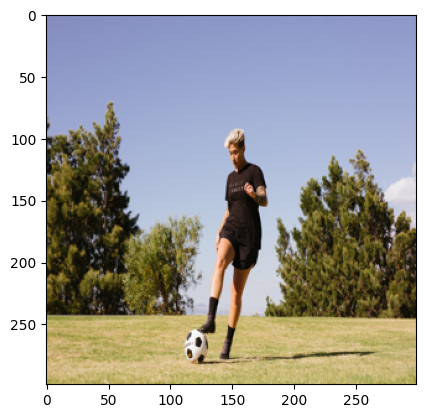

a black and white photo of a person holding a frisbee


In [ ]:
import cv2
from PIL import Image
!wget https://carwow-uk-wp-3.imgix.net/18015-MC20BluInfinito-scaled-e1666008987698.jpg -O img.jpg
img = Image.open('picture.jpg')
img = img.resize((299, 299))

plt.imshow(img)
plt.show()

for i in range(1):
    print(' '.join(generate_caption(model, np.array(img)/255, sample=False, t=1)[1:-1]))

In [ ]:
for i in range(10):
    print(' '.join(generate_caption(model, np.array(img), sample=True, t=1)[1:-1]))

a small dog laying in a basket and rests in a pile
two black sofas sitting next to each other in front of a
the striped teddy bear is sitting by some trees
the old fashioned distance reaches to look like a banana bag
a of an old fashion chair stand in front of his
the men are playing with a cell phone
a man smiling while holding onto a small object
this is a picture of a bird near his
there is a bird on a white tray standing on a twig beside
two phones sitting next to a wooden walk


### Скачаем пару картинок, чтобы проверить качество:

In [ ]:
from matplotlib import pyplot as plt
from scipy.misc import imresize
%matplotlib inline

#sample image
!wget https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg -O img.jpg
img = plt.imread('img.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

In [ ]:
plt.imshow(img)

In [ ]:
for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

In [ ]:
!wget http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg -O img.jpg
img = plt.imread('img.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))